# Efficent data pipeline using tf.data

**Data characteristics:**
* Images (256, 256, 3)
* png format
* mapped through csv file
* RSNA Breast Cancer Detection

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

In [2]:
data = pd.read_csv("train.csv")
data.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [3]:
label = data.loc[:, "cancer"]
label

0        0
1        0
2        0
3        0
4        0
        ..
54701    0
54702    0
54703    0
54704    0
54705    0
Name: cancer, Length: 54706, dtype: int64

In [4]:
image_path = "C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA_SS/Cancer_de_Mama_IA_SS_2023/data/raw_images/"

In [5]:
# Auxiliary function for cnoncatenating the image path
def concat_img_path( patient_id, image_id, img_path = image_path):
    image_path = img_path + str(patient_id) + "_" + str(image_id) + ".png"
    return image_path

# This function will clean the data in order to contain only image path and label
def clean_data(data):
    new_data = data[['cancer']].copy()
    new_data.rename(columns={'cancer': "label"}, inplace=True)
    images_path = []
    for i in range(len(data)):
        image = concat_img_path(data["patient_id"][i], data["image_id"][i])
        images_path.append(image)
    
    new_data['images_path'] = images_path
    new_data = new_data[['images_path', 'label']]
    return new_data 

In [6]:
data_cleaned = clean_data(data)
data_cleaned.head(10)

,images_path,label
0,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,0
1,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,0
2,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,0
3,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,0
4,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,0
5,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,0
6,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,0
7,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,0
8,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,0
9,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,0


In [12]:
data_cleaned.to_csv("images_full_batch.csv", header=False, index=False)

In [10]:
def read_and_decode(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def decode_csv(csv_row):
    record_defaults = ["filepaths", "labels"]
    filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
    img = read_and_decode(filename)
    label = tf.argmax(tf.math.equal(["0","1"], label_string))
    return img, label

In [46]:
dataset = tf.data.TextLineDataset("images_full_batch.csv")

In [47]:
dataset

<TextLineDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [48]:
for element in dataset.take(1):
    print(element)

tf.Tensor(b'C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA_SS/Cancer_de_Mama_IA_SS_2023/data/raw_images/10006_462822612.png,0', shape=(), dtype=string)


In [49]:
dataset = dataset.map(decode_csv).batch(32)

In [50]:
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [51]:
for image, label in dataset.take(1):
    print(image)
    print(label)

tf.Tensor(
[[[[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  ...

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.      

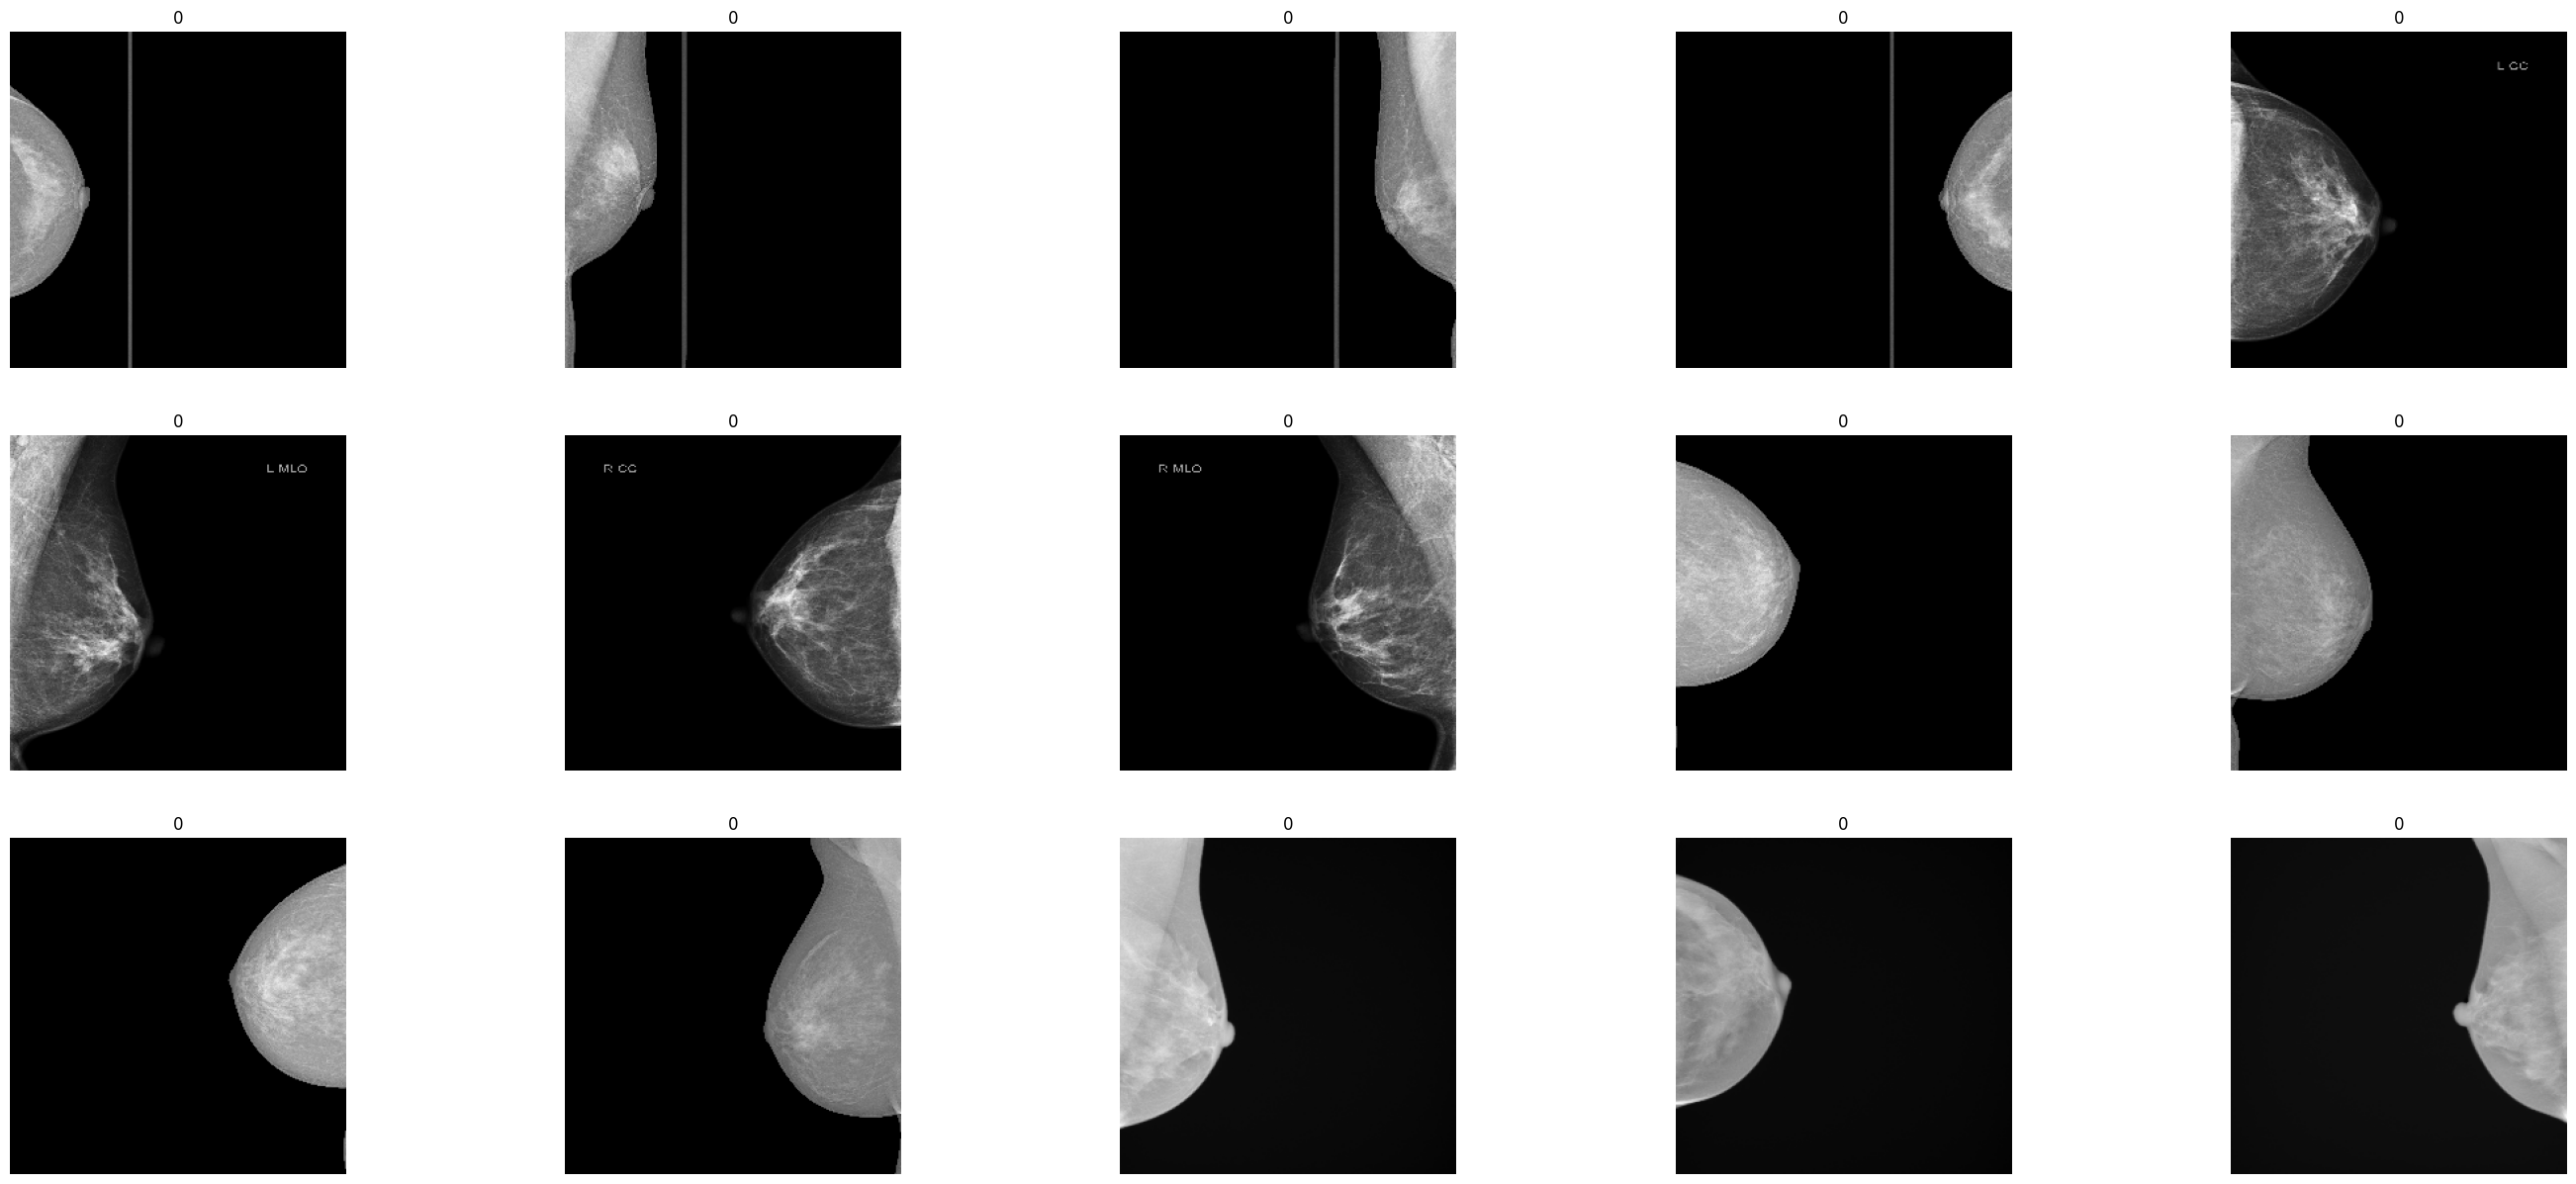

In [81]:
# Visualize the data
import matplotlib.pyplot as plt

dataset = (tf.data.TextLineDataset(
    "images_full_batch.csv").
    map(decode_csv))
f, ax = plt.subplots(3, 5, figsize=(35,15))
for idx, (images, labels) in enumerate(dataset.take(15)):
    ax[idx//5, idx%5].imshow((images.numpy()));
    ax[idx//5, idx%5].set_title(str(labels.numpy()));
    ax[idx//5, idx%5].axis('off')

In [83]:
dataset = (tf.data.TextLineDataset(
    "images_full_batch.csv").
    map(decode_csv)).batch(32)


for imageh, labels in dataset:
    print(image.shape)
    print(labels.shape)
    break

(32, 256, 256, 3)
(32,)


In [84]:
AUTOTUNE = tf.data.AUTOTUNE

In [86]:
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [87]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>